In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from khayyam import JalaliDate
from plotly.subplots import make_subplots
import cufflinks as cf
import plotly.graph_objs as go
from statsmodels.tsa.stattools import adfuller
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
cf.go_offline()
import warnings
from sklearn.model_selection import train_test_split  

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
df= pd.read_excel(r"C:\Users\ASUS\Desktop\parsiantejarat\data.xlsx")

In [3]:
df.columns = df.columns.str.replace("/", "-")
def shamsi_to_gregorian(column_name):
    if '-' in column_name:  # Check if column name is in the format '1401/01'
        year, month = map(int, column_name.split('-'))
        gregorian_date = JalaliDate(year, month, 1).todate()  # Convert to Gregorian date
        return gregorian_date.strftime('%Y-%m')  # Convert to 'YYYY-MM' format
   

# Apply the conversion to the columns
df.columns = [shamsi_to_gregorian(col) for col in df.columns]
df_transposed=df.transpose()
df_transposed.columns = df_transposed.iloc[0]
df_last=df_transposed.iloc[1:]
df_last.index = pd.to_datetime(df_last.index.values, format='%Y-%m-%d', errors='coerce') 

## 1. Data visualization 📊

In [161]:

df_last.iplot(
    kind='line',  
    xTitle='Time',  
    yTitle='Values', 
    title='Time Series Plot', 
    legend=True,  
    asFigure=False  
)


In [178]:
fig = make_subplots(rows=4, cols=8, subplot_titles=df_last.columns)


for i, col in enumerate(df_last.columns):
    row = i // 8 + 1  # Determine the row number
    col_num = i % 8 + 1  # Determine the column number
    fig.add_trace(
        go.Scatter(x=df_last.index, y=df_last[col], name=col),
        row=row, col=col_num
    )


fig.update_layout(
    height=1000, 
    width=1400,   
    title_text="Time Series Subplots for 32 Columns",
    showlegend=False  
)

# Show the figure
fig.show()

## 2. Data Preprocessing ⚙️

In [31]:
df_last.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 2022-03 to 2024-02
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   تهران                 24 non-null     object
 1   آذربایجان شرقی        24 non-null     object
 2   آذربایجان غربی        24 non-null     object
 3   اردبیل                24 non-null     object
 4   اصفهان                24 non-null     object
 5   البرز                 24 non-null     object
 6   ایلام                 24 non-null     object
 7   بوشهر                 24 non-null     object
 8   چهارمحال و بختیاری    24 non-null     object
 9   خراسان جنوبی          24 non-null     object
 10  خراسان رضوی           24 non-null     object
 11  خراسان شمالی          24 non-null     object
 12  خوزستان               24 non-null     object
 13  زنجان                 24 non-null     object
 14  سمنان                 24 non-null     object
 15  سیستان و بلوچستان     24 non-null   

In [34]:
df_last.describe()

,تهران,آذربایجان شرقی,آذربایجان غربی,اردبیل,اصفهان,البرز,ایلام,بوشهر,چهارمحال و بختیاری,خراسان جنوبی,...,کهگیلویه و بویر احمد,گلستان,گیلان,لرستان,مازندران,مرکزی,هرمزگان,همدان,یزد,مجموع
count,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,...,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01
unique,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,...,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01
top,9.980393e+08,2.058755e+08,1.949486e+08,6.729548e+07,2.885885e+08,1.465697e+08,2.581758e+07,1.035109e+08,3.966941e+07,2.896567e+07,...,3.026795e+07,8.781500e+07,1.745935e+08,6.681637e+07,2.386717e+08,6.161467e+07,1.685825e+08,7.625968e+07,7.083313e+07,4.711607e+09
freq,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### 2.1 Handle Missings

In [32]:
df_last.isnull().sum()

تهران                   0
آذربایجان شرقی          0
آذربایجان غربی          0
اردبیل                  0
اصفهان                  0
البرز                   0
ایلام                   0
بوشهر                   0
چهارمحال و بختیاری      0
خراسان جنوبی            0
خراسان رضوی             0
خراسان شمالی            0
خوزستان                 0
زنجان                   0
سمنان                   0
سیستان و بلوچستان       0
فارس                    0
قزوین                   0
قم                      0
کردستان                 0
کرمان                   0
کرمانشاه                0
کهگیلویه و بویر احمد    0
گلستان                  0
گیلان                   0
لرستان                  0
مازندران                0
مرکزی                   0
هرمزگان                 0
همدان                   0
یزد                     0
مجموع                   0
dtype: int64

### 2.2 Stationarity

Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has

constant mean and mean is not time-dependent
constant variance and variance is not time-dependent
constant covariance and covariance is not time-dependent


The check for stationarity can be done via three different approaches:

visually: plot time series and check for trends or seasonality
basic statistics: split time series and compare the mean and variance of each partition
statistical test: Augmented Dickey Fuller test

In [76]:


result = adfuller(df_last['مجموع'].values)
result

(-1.5333739738809955,
 0.5169418885358664,
 0,
 23,
 {'1%': -3.7529275211638033,
  '5%': -2.998499866852963,
  '10%': -2.6389669754253307},
 621.8732091785619)

#### Breaking it down:
Test Statistic (-1.5333739738809955):

It measures how strongly a time series is likely to be non-stationary. The more negative it is, the stronger the evidence that the series is stationary.
In this case, the test statistic is -1.5334.
p-value (0.5169418885358664):

The p-value tells us whether to reject the null hypothesis. The null hypothesis of the ADF test is that the time series has a unit root (i.e., it is non-stationary).
A p-value greater than 0.05 indicates that we fail to reject the null hypothesis, meaning that the series is likely non-stationary.
In this case, the p-value is 0.5169, which is significantly higher than 0.05, suggesting that the series is non-stationary.
Number of Lags Used (0):

This is the number of lags used in the test to account for autocorrelation. Here, no lags were used (0 lags).
Number of Observations Used (23):

This indicates the number of observations used in the test, which is 23.
Critical Values ({'1%': -3.7529, '5%': -2.9985, '10%': -2.6390}):

These are the critical values for the test at the 1%, 5%, and 10% significance levels. If the test statistic is less than (more negative than) the critical value, we reject the null hypothesis at that significance level.

For example:

At the 1% level, the critical value is -3.7529.
At the 5% level, it is -2.9985.
At the 10% level, it is -2.6390.
In your case, the test statistic (-1.5334) is not more negative than any of the critical values, meaning that the series is non-stationary even at the 10% significance level.

Maximized Information Criterion (AIC) (621.8732091785619):

This value refers to the Akaike Information Criterion (AIC), which is used to select the best fitting model. A lower AIC suggests a better model fit. However, this value is more relevant in model selection rather than interpreting the stationarity of the series.
Conclusion:
The p-value of 0.5169 is greater than 0.05, which means we fail to reject the null hypothesis that the series has a unit root. This indicates that the time series df_last['مجموع'] is non-stationary.
The test statistic (-1.5334) is not smaller than any of the critical values (-3.7529, -2.9985, -2.6390), further confirming that the series is non-stationary.

If the data is not stationary but we want to use a model such as ARIMA (that requires this characteristic), the data has to be transformed.

The two most common methods to transform series into stationarity ones are:

Transformation: e.g. log or square root to stabilize non-constant variance
Differencing: subtracts the current value from the previous

### 2.2.1 Transforming

In [77]:
# Function to perform ADF test and check stationarity
def adf_test(series):
    result = adfuller(series)
    return result[1]  

# Function to check stationarity and differencing
def check_stationarity_and_differentiate(df):
    for column in df.columns:
        print(f"\nChecking stationarity for {column}:")
        p_value = adf_test(df[column])
        print('p-value:', p_value)
        
        if p_value > 0.05:
            print("The series is non-stationary. Applying differencing...")
            df[f'differenced_{column}'] = df[column].diff()
            
            # Check stationarity after differencing
            new_p_value = adf_test(df[f'differenced_{column}'].dropna())
            print(f"After differencing, p-value: {new_p_value}")
            if new_p_value <= 0.05:
                print("The differenced series is now stationary.")
            else:
                print("The differenced series is still non-stationary.")
        else:
            print("The series is stationary, no differencing needed.")

# Check stationarity and differencing for all provinces
check_stationarity_and_differentiate(df_last)


Checking stationarity for تهران:
p-value: 0.22974975550378818
The series is non-stationary. Applying differencing...
After differencing, p-value: 2.7210420771343107e-05
The differenced series is now stationary.

Checking stationarity for آذربایجان شرقی:
p-value: 0.44700634082101276
The series is non-stationary. Applying differencing...
After differencing, p-value: 3.052106256615121e-05
The differenced series is now stationary.

Checking stationarity for آذربایجان غربی:
p-value: 0.5882230631836616
The series is non-stationary. Applying differencing...
After differencing, p-value: 4.517165674961344e-06
The differenced series is now stationary.

Checking stationarity for اردبیل:
p-value: 0.4397497203828561
The series is non-stationary. Applying differencing...
After differencing, p-value: 9.552088444166788e-06
The differenced series is now stationary.

Checking stationarity for اصفهان:
p-value: 0.3608748530441206
The series is non-stationary. Applying differencing...
After differencing, 

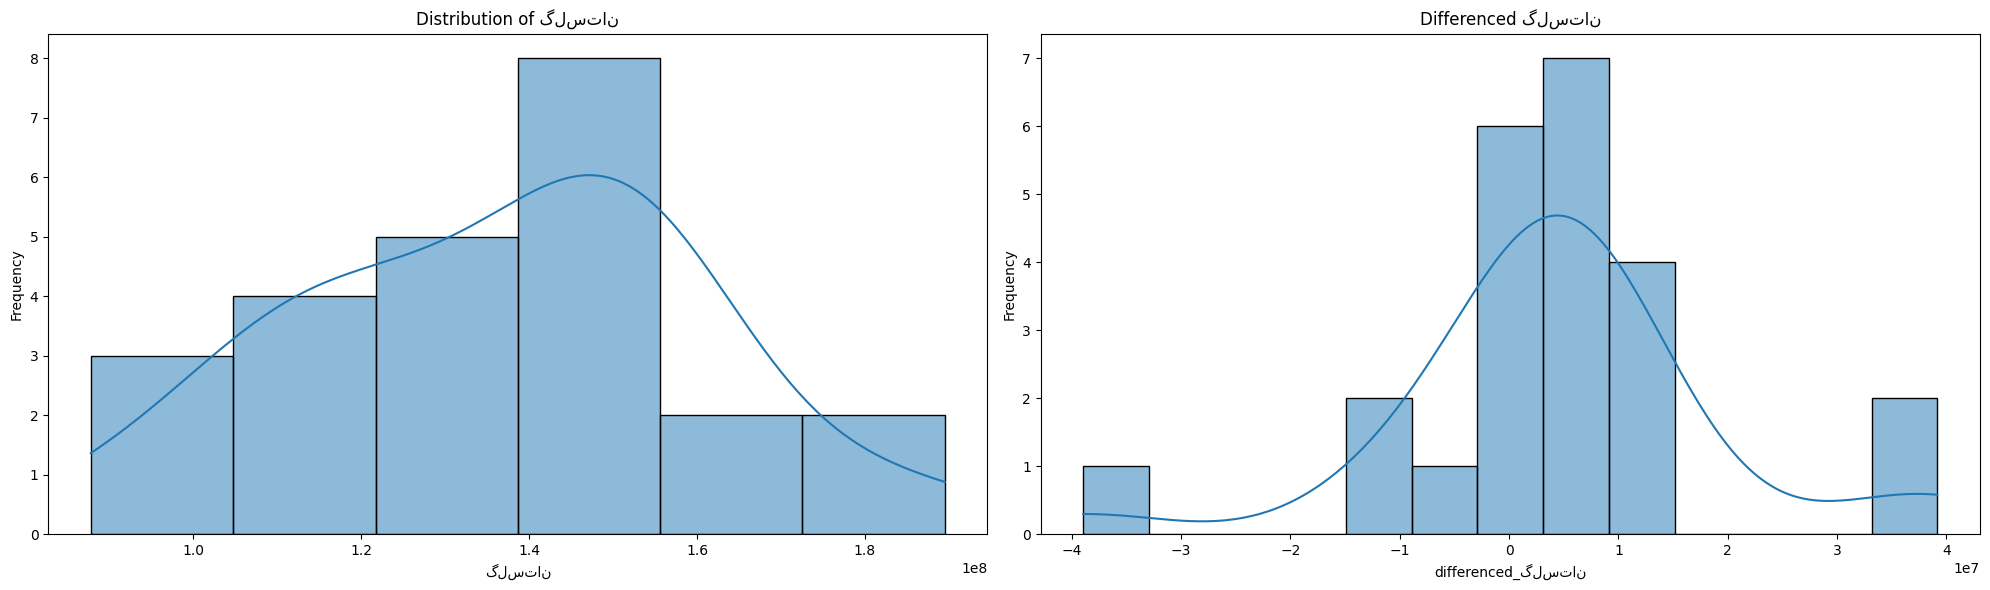

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot histogram for 'گلستان'
sns.histplot(df_last['گلستان'], ax=ax[0], kde=True)  # Add kde=True to overlay a density curve
ax[0].set_title('Distribution of گلستان')
ax[0].set_ylabel('Frequency')

# Plot histogram for 'differenced_گلستان'
sns.histplot(df_last['differenced_گلستان'].dropna(), ax=ax[1], kde=True)  # Drop NA values if present
ax[1].set_title('Differenced گلستان')
ax[1].set_ylabel('Frequency')

# Show the plot
plt.tight_layout()

plt.show()

## 3. Feature engineering 🔧

2022-03-01   -8.739976e+08
2022-04-01    5.910269e+06
2022-05-01    5.802861e+07
2022-06-01   -2.384851e+08
2022-07-01   -4.697888e+08
2022-08-01   -1.232176e+08
2022-09-01   -6.961056e+08
2022-10-01   -3.801155e+08
2022-11-01    2.067443e+07
2022-12-01   -7.236828e+07
2023-01-01    4.034855e+08
2023-02-01    2.365980e+09
2023-03-01   -8.739976e+08
2023-04-01    5.910269e+06
2023-05-01    5.802861e+07
2023-06-01   -2.384851e+08
2023-07-01   -4.697888e+08
2023-08-01   -1.232176e+08
2023-09-01   -6.961056e+08
2023-10-01   -3.801155e+08
2023-11-01    2.067443e+07
2023-12-01   -7.236828e+07
2024-01-01    4.034855e+08
2024-02-01    2.365980e+09
Name: seasonal, dtype: float64


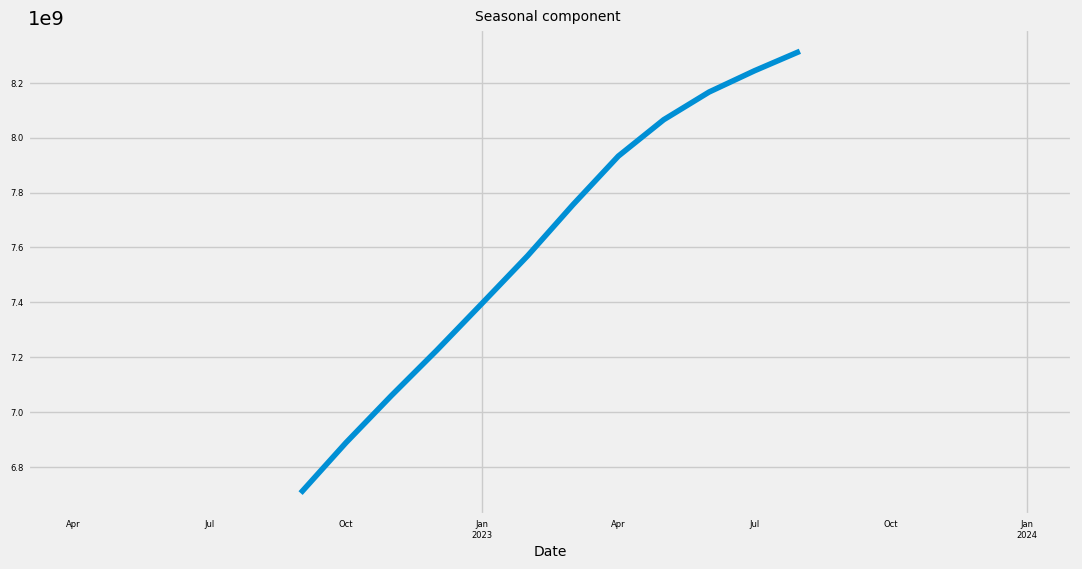

In [144]:

import statsmodels.api as sm

# Perform time series decompositon
decomposition = sm.tsa.seasonal_decompose(df_last['مجموع'])

# Print the seasonality component
print(decomposition.seasonal)

# Extract the trend component
trend = decomposition.trend

# Plot the values of the trend
ax = trend.plot(figsize=(12, 6), fontsize=6)

# Specify axis labels
ax.set_xlabel('Date', fontsize=10)
ax.set_title('Seasonal component ', fontsize=10)
plt.show()

## 4. Exploratory Data Analysis 📊

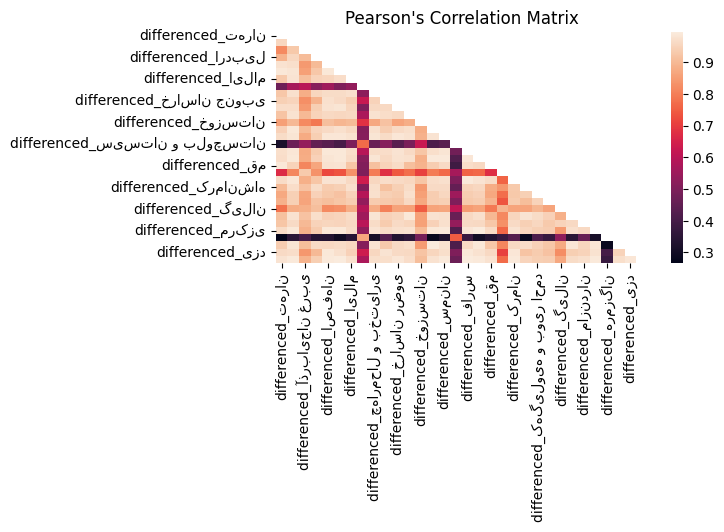

In [120]:
corr = df_last[cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(6, 3))
sns.heatmap(corr, mask=mask, fmt=".2f", linecolor="c")
plt.title("Pearson's Correlation Matrix")
plt.show()

In [122]:
import numpy as np
import pandas as pd
from scipy.stats import zscore, median_abs_deviation
from scipy.stats.mstats import winsorize
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

outlier_detection_results = {}
outlier_detection_results_after_log = {}
# Function to apply all outlier detection methods
def detect_outliers(column):
    results = {}
    data = df_last[column].dropna()  # Drop NA values for the column
    
    # Z-score method
    z_scores = zscore(data)
    outliers_z = np.where(np.abs(z_scores) > 3)[0]
    results['Z-score'] = outliers_z.tolist()
    
    # Robust Z-score method
    median = np.median(data)
    mad = median_abs_deviation(data)
    robust_z_scores = [(x - median) / mad for x in data]
    outliers_robust_z = np.where(np.abs(robust_z_scores) > 3)[0]
    results['Robust Z-score'] = outliers_robust_z.tolist()
    
    # IQR method
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    outliers_iqr = np.where((data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR))[0]
    results['IQR'] = outliers_iqr.tolist()
    
  
    
    # DBSCAN Clustering
    dbscan = DBSCAN(eps=3, min_samples=2)
    labels = dbscan.fit_predict(data.values.reshape(-1, 1))
    outliers_dbscan = np.where(labels == -1)[0]
    results['DBSCAN'] = outliers_dbscan.tolist()
    
    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.1)
    iso_labels = iso_forest.fit_predict(data.values.reshape(-1, 1))
    outliers_isoforest = np.where(iso_labels == -1)[0]
    results['Isolation Forest'] = outliers_isoforest.tolist()
    
    return results

# Apply outlier detection to all numerical columns
for column in cols:
    outlier_detection_results[column] = detect_outliers(column)

# Print the results
for column, results in outlier_detection_results.items():
    print(f"Column: {column}")
    for method, outliers in results.items():
        print(f"  {method} method detected {len(outliers)} outliers.")
    print("\n")

Column: differenced_تهران
  Z-score method detected 1 outliers.
  Robust Z-score method detected 6 outliers.
  IQR method detected 4 outliers.
  DBSCAN method detected 22 outliers.
  Isolation Forest method detected 3 outliers.


Column: differenced_آذربایجان شرقی
  Z-score method detected 1 outliers.
  Robust Z-score method detected 5 outliers.
  IQR method detected 3 outliers.
  DBSCAN method detected 22 outliers.
  Isolation Forest method detected 3 outliers.


Column: differenced_آذربایجان غربی
  Z-score method detected 0 outliers.
  Robust Z-score method detected 3 outliers.
  IQR method detected 3 outliers.
  DBSCAN method detected 22 outliers.
  Isolation Forest method detected 3 outliers.


Column: differenced_اردبیل
  Z-score method detected 0 outliers.
  Robust Z-score method detected 3 outliers.
  IQR method detected 3 outliers.
  DBSCAN method detected 22 outliers.
  Isolation Forest method detected 3 outliers.


Column: differenced_اصفهان
  Z-score method detected 1 outlie

### 3.1 Autocorrelation Analysis
Autocorrelation plots help in detecting seasonality.

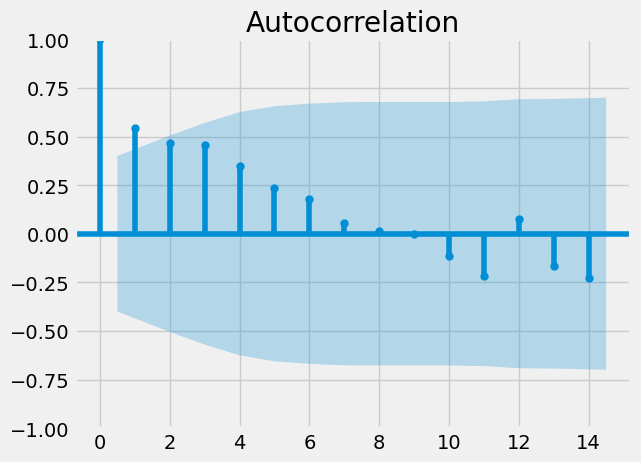

In [11]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from statsmodels.graphics import tsaplots

# Display the autocorrelation plot of your time series
fig = tsaplots.plot_acf(df_last['مجموع'])

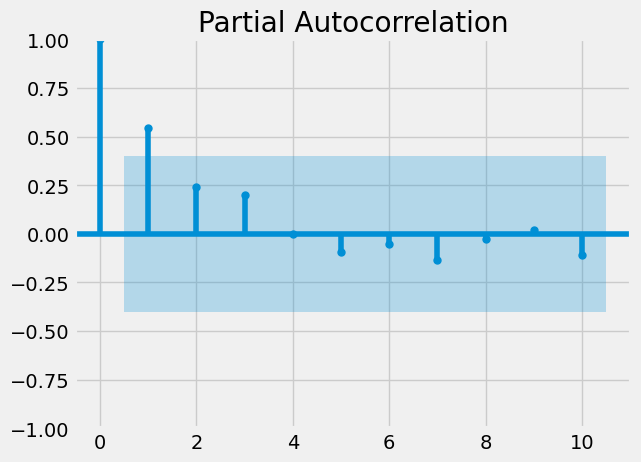

In [20]:
fig = tsaplots.plot_pacf(df_last['مجموع'],lags=10)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

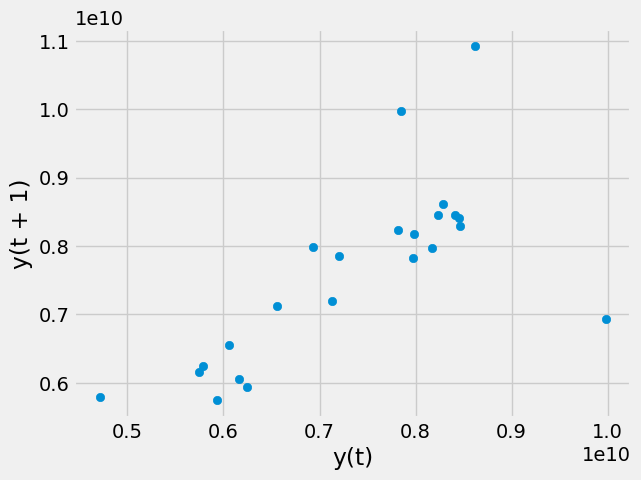

In [15]:
from pandas.plotting import lag_plot
lag_plot(df_last['مجموع'])

## 5. Modeling 🧩

consider taking the total value for all regions or focusing on an individual region's data series.in this section i focuse on an individual region's data series

In [62]:
import pandas as pd  
import matplotlib.pyplot as plt  
from statsmodels.tsa.arima_model import ARIMA,ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

### 5.1 SARIMA
------------------------------------------------------

In [47]:
df_last["مجموع"] = pd.to_numeric(df_last["مجموع"], errors='coerce')

In [48]:
result = adfuller(df_last["مجموع"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.5333739738809955
p-value: 0.5169418885358664


In [99]:
train=df_last["مجموع"].iloc[:20]
test=df_last["مجموع"].iloc[20:]
# train["_مجموع"] = pd.to_numeric(train["مجموع"], errors='coerce')
SARIMA_model=SARIMAX(train,order=(0,2,1),seasonal_decompose=(0,2,1,12))
SARIMA_fit=SARIMA_model.fit()



In [101]:
SARIMA_pred=SARIMA_fit.predict(start=23,end=36).rename("SARIMA_fit prediction")


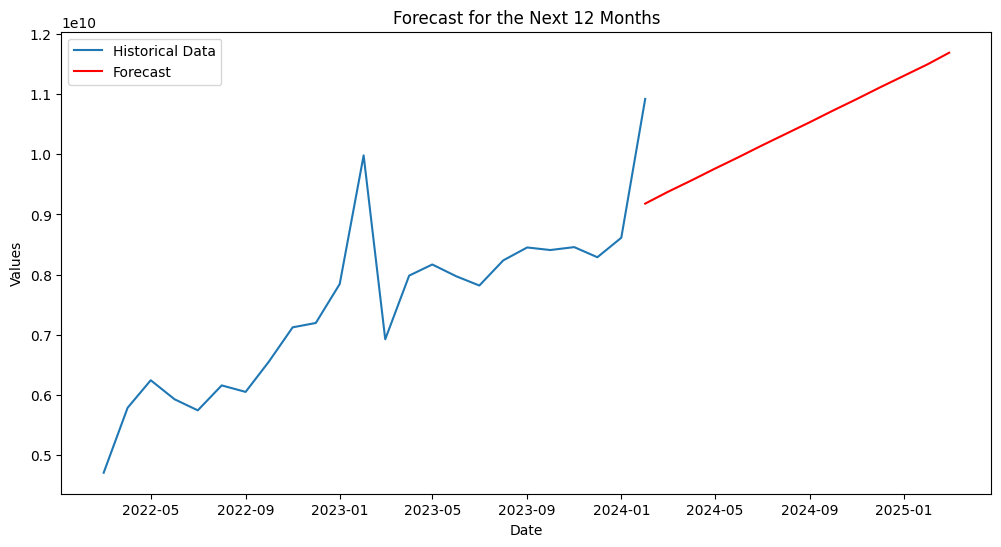

In [102]:
plt.figure(figsize=(12, 6))  
plt.plot(df_last["مجموع"], label='Historical Data')  
plt.plot(SARIMA_pred, label='Forecast', color='red')  
plt.title('Forecast for the Next 12 Months')  
plt.xlabel('Date')  
plt.ylabel('Values')  
plt.legend()  
plt.show() 

### 5.2 Auto-ARIMA
------------------------------------------------------

**Auto-ARIMA** is a model selection technique used in time series analysis to automatically identify the appropriate parameters for an ARIMA.. The ARIMA model combines three components:
AR (AutoRegressive): This part uses the dependency between an observation and a number of lagged observations (previous time points).
I (Integrated): This part involves differencing the data to make it stationary, which means removing trends and seasonality.
MA (Moving Average): This part uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
Auto-ARIMA automatically determines the best values for the AR, I, and MA parameters (p, d, q) using statistical algorithms.

In [56]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(df_last['مجموع'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=994.694, Time=0.91 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=998.061, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=994.289, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=992.087, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=996.175, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=994.092, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 1.329 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -493.043
Date:                Tue, 08 Oct 2024   AIC                            992.087
Time:                        09:42:09   BIC         

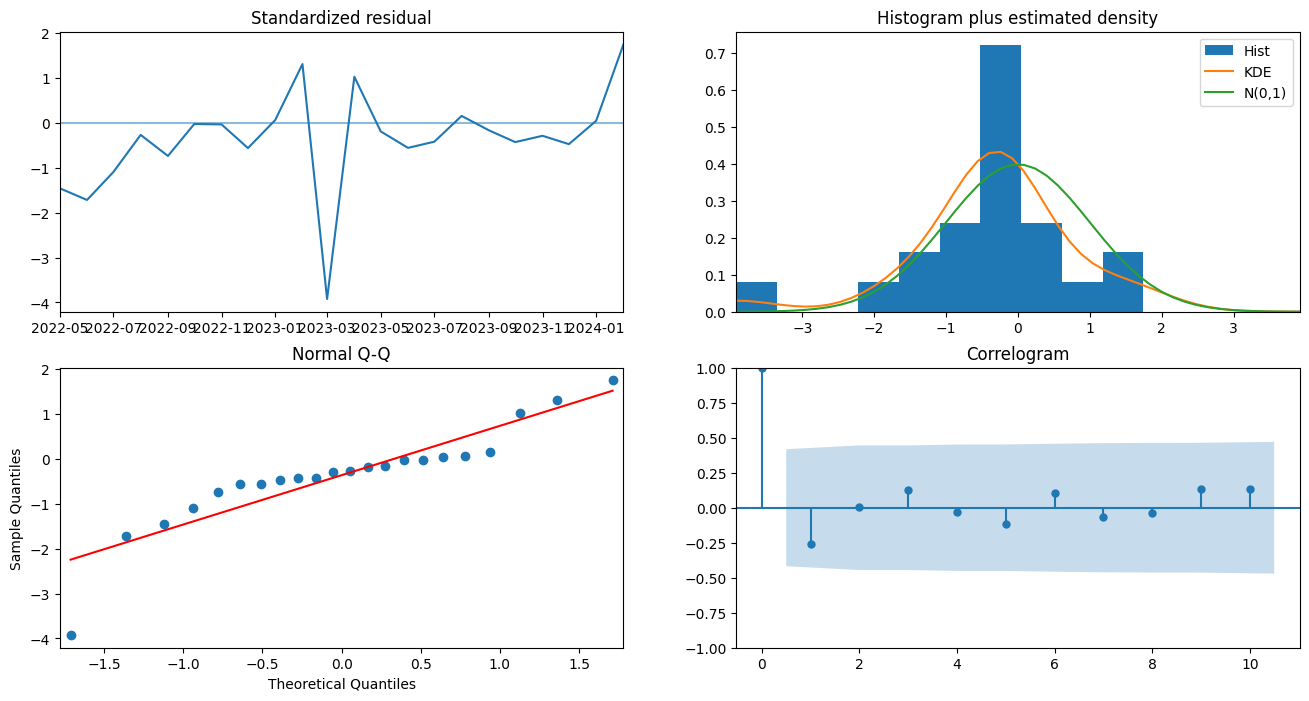

In [57]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

**interpret the plot :**

**Top left:**  The residual errors seem to fluctuate around a mean of zero and have a  variance between (-4, 1).

**Top Right:** The density plot suggest normal distribution with mean zero.

**Bottom left:** The less part of the blue dots are over the red line, so it seems that the distribution is skewed .

**Bottom Right:** all lags are within the confidence bounds, this suggests that the model is well-fitted and the residuals are behaving like white noise (i.e., random and uncorrelated).
Residuals should not show significant autocorrelation at any lag (bars should stay within the confidence bounds). If autocorrelations are present, it indicates that the model has not fully captured all the patterns in the data.

### 5.3 ARIMA
----------------------------------------------------------

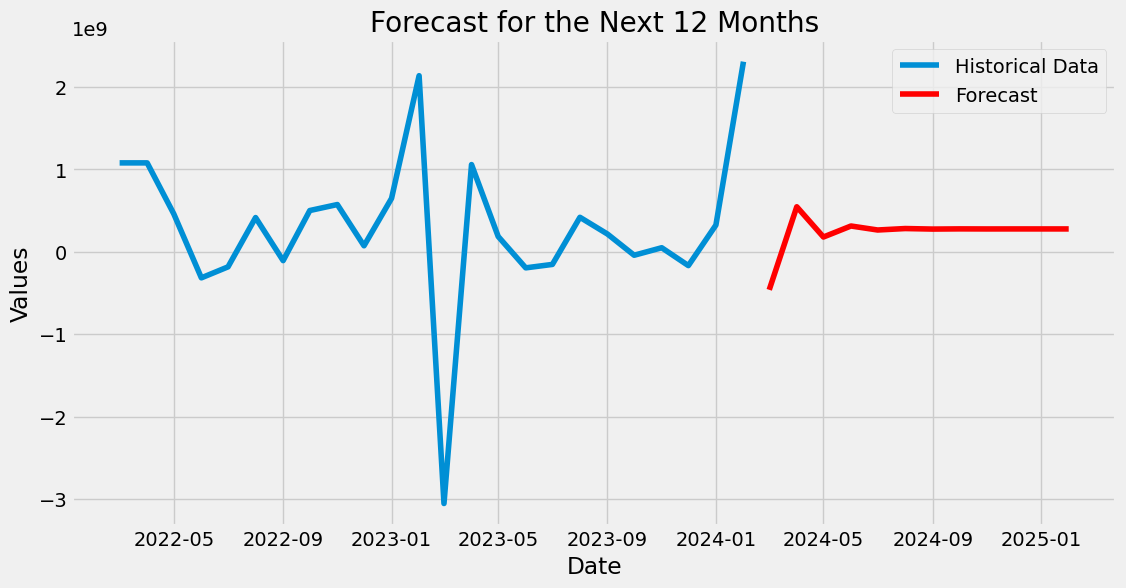

In [178]:
import pandas as pd  
import matplotlib.pyplot as plt  
from statsmodels.tsa.arima.model import ARIMA  


  
monthly_data = df_last['differenced_مجموع']  

# Fit the ARIMA model  
model = ARIMA(monthly_data, order=(1, 1, 1)) 
model_fit = model.fit()  

# Forecast for the next 12 months  
forecast = model_fit.forecast(steps=12)  

# Plot the results  
plt.figure(figsize=(12, 6))  
plt.plot(monthly_data, label='Historical Data')  
plt.plot(forecast, label='Forecast', color='red')  
plt.title('Forecast for the Next 12 Months')  
plt.xlabel('Date')  
plt.ylabel('Values')  
plt.legend()  
plt.show()  

In [184]:
forecast

2024-03-01   -4.619047e+08
2024-04-01    5.453101e+08
2024-05-01    1.786903e+08
2024-06-01    3.121376e+08
2024-07-01    2.635636e+08
2024-08-01    2.812443e+08
2024-09-01    2.748086e+08
2024-10-01    2.771512e+08
2024-11-01    2.762985e+08
2024-12-01    2.766089e+08
2025-01-01    2.764959e+08
2025-02-01    2.765370e+08
Freq: MS, Name: predicted_mean, dtype: float64

### 5.4 ML Models (RandomForest_model,LinearRegression)
-------------------------------------------------------


In [83]:
df_last['total_LastMonth']=df_last['مجموع'].shift(+1)
df_last['total_2Monthsback']=df_last['مجموع'].shift(+2)
df_last['total_3Monthsback']=df_last['مجموع'].shift(+3)
df_ml=df_last.dropna()
x1,x2,x3,y=df_ml['total_LastMonth'],df_ml['total_2Monthsback'],df_ml['total_3Monthsback'],df_ml['مجموع']
x1,x2,x3,y=np.array(x1),np.array(x2),np.array(x3),np.array(y)
x1,x2,x3,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x=np.concatenate((x1,x2,x3),axis=1)
X_train,X_test,y_train,y_test=train_test_split(final_x, y, test_size=0.2, random_state=42)
print("Training Features:", X_train)  
print("Testing Features:", X_test)  
print("Training Labels:", y_train)  
print("Testing Labels:", y_test)
     

Training Features: [[6.55356629e+09 6.05379519e+09 6.16167987e+09]
 [7.98440553e+09 6.92724801e+09 9.98080360e+09]
 [6.16167987e+09 5.74721664e+09 5.93050406e+09]
 [8.45788520e+09 8.40937670e+09 8.45197695e+09]
 [8.45197695e+09 8.23761920e+09 7.81998356e+09]
 [7.97381384e+09 8.16934842e+09 7.98440553e+09]
 [5.74721664e+09 5.93050406e+09 6.24724116e+09]
 [9.98080360e+09 7.84544663e+09 7.19808964e+09]
 [8.61328989e+09 8.28960973e+09 8.45788520e+09]
 [6.05379519e+09 6.16167987e+09 5.74721664e+09]
 [8.16934842e+09 7.98440553e+09 6.92724801e+09]
 [7.19808964e+09 7.12590664e+09 6.55356629e+09]
 [6.92724801e+09 9.98080360e+09 7.84544663e+09]
 [7.81998356e+09 7.97381384e+09 8.16934842e+09]
 [8.28960973e+09 8.45788520e+09 8.40937670e+09]
 [7.12590664e+09 6.55356629e+09 6.05379519e+09]]
Testing Features: [[6.24724116e+09 5.78930283e+09 4.71160722e+09]
 [8.40937670e+09 8.45197695e+09 8.23761920e+09]
 [8.23761920e+09 7.81998356e+09 7.97381384e+09]
 [5.93050406e+09 6.24724116e+09 5.78930283e+09]
 [

In [84]:
lin_model=LinearRegression()
RandomForest_model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)
RandomForest_model.fit(X_train,y_train)
lin_model.fit(X_train,y_train)

LinearRegression()

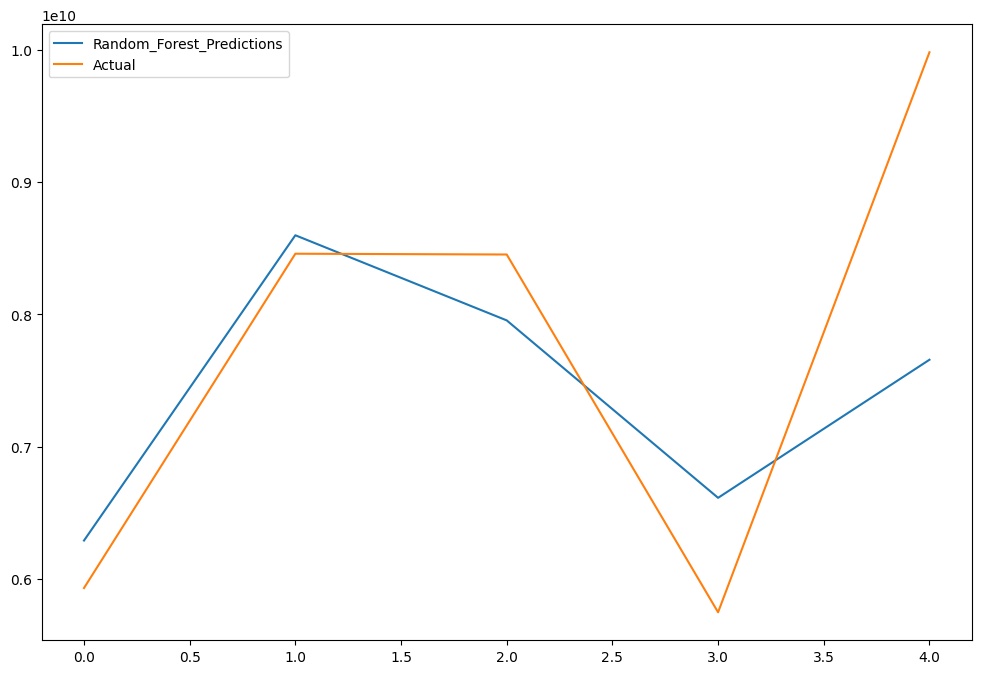

In [85]:

pred=RandomForest_model.predict(X_test)
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(pred,label='Random_Forest_Predictions')
plt.plot(y_test,label='Actual')
plt.legend(loc="upper left")
plt.show()

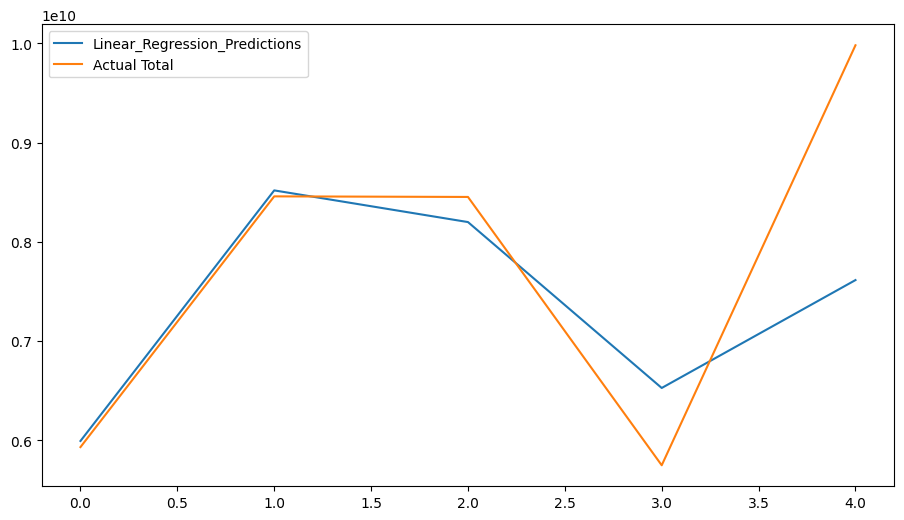

In [86]:

lin_pred=lin_model.predict(X_test)
plt.rcParams["figure.figsize"] = (11,6)
plt.plot(lin_pred,label='Linear_Regression_Predictions')
plt.plot(y_test,label='Actual Total')
plt.legend(loc="upper left")
plt.show()

In [87]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_rf=sqrt(mean_squared_error(pred,y_test))
rmse_lr=sqrt(mean_squared_error(lin_pred,y_test))

### 5.5 LSTM
_____________________________________________________________

In [4]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [5]:
df_lstm=df_last[["مجموع"]]

In [122]:
train=df_last[["مجموع"]]
# test=df_last[["مجموع"]][20:]

In [123]:

scaler = MinMaxScaler()
scaler.fit(train)
scaled_train=scaler.transform(train)
# scaled_test=scaler.transform(test)


In [129]:
# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [130]:
model_ls = Sequential()
model_ls.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_ls.add(Dense(1))
model_ls.compile(optimizer='adam', loss='mse')

In [131]:
model_ls.fit_generator(generator,epochs=50)


Epoch 1/50
12/12 [==============================] - 2s 8ms/step - loss: 0.3267
Epoch 2/50
12/12 [==============================] - 0s 11ms/step - loss: 0.1165
Epoch 3/50
12/12 [==============================] - 0s 10ms/step - loss: 0.0355
Epoch 4/50
12/12 [==============================] - 0s 10ms/step - loss: 0.0193
Epoch 5/50
12/12 [==============================] - 0s 9ms/step - loss: 0.0126
Epoch 6/50
12/12 [==============================] - 0s 9ms/step - loss: 0.0177
Epoch 7/50
12/12 [==============================] - 0s 9ms/step - loss: 0.0201
Epoch 8/50
12/12 [==============================] - 0s 8ms/step - loss: 0.0118
Epoch 9/50
12/12 [==============================] - 0s 10ms/step - loss: 0.0137
Epoch 10/50
12/12 [==============================] - 0s 10ms/step - loss: 0.0139
Epoch 11/50
12/12 [==============================] - 0s 9ms/step - loss: 0.0129
Epoch 12/50
12/12 [==============================] - 0s 40ms/step - loss: 0.0132
Epoch 13/50
12/12 [========================

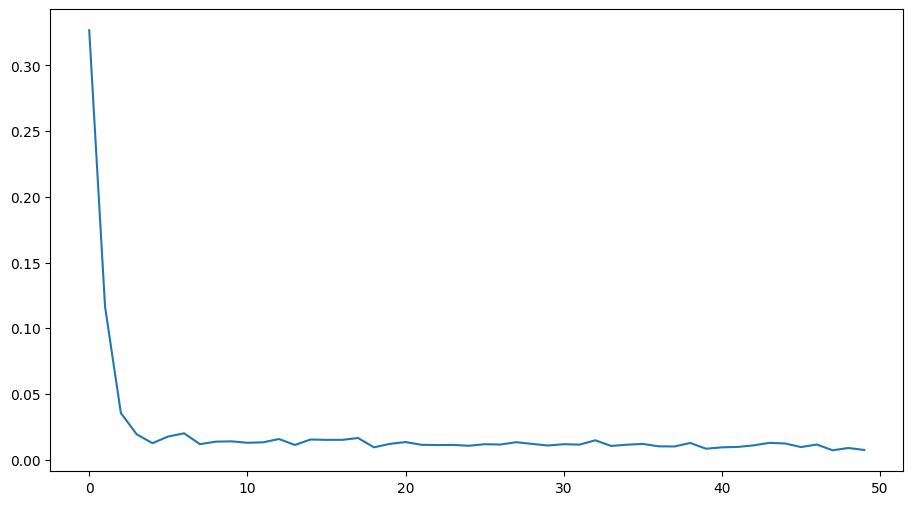

In [132]:
loss_per_epoch = model_ls.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [135]:
test

,مجموع
2023-11-01,8457885204.084438
2023-12-01,8289609728.094483
2024-01-01,8613289888.130478
2024-02-01,10918507216.936815


In [166]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(24):
    
    # get the prediction value for the first batch
    current_pred = model_ls.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

1/1 [==============================] - 0s 24ms/step


In [167]:
true_predictions = scaler.inverse_transform(test_predictions)

In [164]:
true_predictions


array([[8.86135942e+09],
       [9.24830288e+09],
       [9.42285189e+09],
       [9.48715206e+09],
       [9.58656181e+09],
       [9.88166379e+09],
       [1.01107893e+10],
       [1.02573656e+10],
       [1.04569916e+10],
       [1.05964895e+10],
       [1.10809922e+10],
       [1.23194180e+10],
       [1.14198653e+10],
       [1.19023398e+10],
       [1.23087469e+10],
       [1.26997614e+10],
       [1.31741589e+10],
       [1.38363468e+10],
       [1.45349313e+10],
       [1.52849994e+10],
       [1.62163761e+10],
       [1.73090332e+10],
       [1.91580418e+10],
       [2.20586797e+10],
       [2.26749829e+10],
       [2.61567318e+10],
       [3.07744654e+10],
       [3.74678481e+10],
       [4.82336447e+10],
       [6.70232477e+10],
       [9.99176938e+10],
       [1.59263746e+11],
       [2.66144074e+11],
       [4.61925474e+11],
       [8.51378568e+11],
       [1.46647273e+12]])

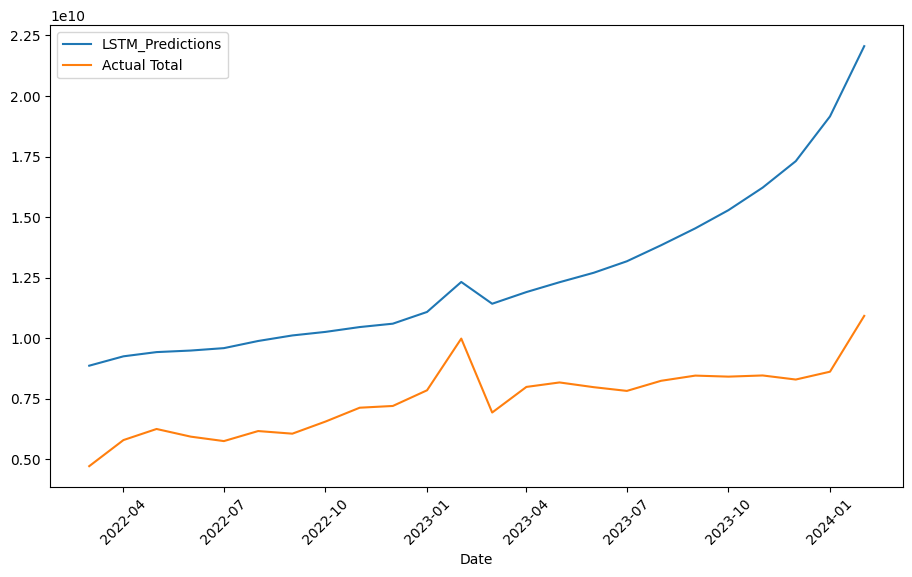

In [168]:
plt.rcParams["figure.figsize"] = (11,6)

# Use the test set index for the x-axis
plt.plot(train.index,true_predictions, label='LSTM_Predictions')
plt.plot(train.index,train["مجموع"].values, label='Actual Total')

plt.legend(loc="upper left")
plt.xlabel("Date") 
plt.xticks(rotation=45) 
plt.show()
